In [2]:
from pathlib import Path
import pandas as pd
import numpy as np
import seaborn as sn
import json
import random
sn.set_theme(style="ticks")
import warnings
warnings.filterwarnings('ignore')


In [2]:
def json_to_df(json_file: str) -> pd.DataFrame:
    with open(json_file) as f:
        data = json.load(f)
        f.close()
        
    instance_id_list = []
    goal_achieved_list = []
    content_list = []
    actions_text_list = []
    actions_possible_list = []
    n_actions_list = []
    for instance_id, value in data.items():
        value = value["chat_with_possible_actions"]
        goal_achieved = value["goal_achieved"]
        content = value["content"]
        actions = value["actions"]
        actions_text = [action[0] for _ , action in actions.items()]
        n_actions = len(actions_text)
        actions_possible = [str(int(action[1])) for _ , action in actions.items()]
        actions_text = ".".join(actions_text)
        actions_possible = ".".join(actions_possible)
        
        instance_id_list.append(instance_id)
        goal_achieved_list.append(goal_achieved)
        content_list.append(content)
        actions_text_list.append(actions_text)
        actions_possible_list.append(actions_possible)
        n_actions_list.append(n_actions)

    df = pd.DataFrame({
        "instance_id": instance_id_list,
        "goal_achieved": goal_achieved_list,
        "content": content,
        "actions_text": actions_text_list,
        "actions_possible": actions_possible_list,
        "n_actions": n_actions_list
    })
    
    return df

In [3]:
def json_to_df_without_checking_actions(json_file: str) -> pd.DataFrame:
    with open(json_file) as f:
        data = json.load(f)
        f.close()
    instance_id_list = []
    goal_achieved_list = []
    content_list = []
    actions_text_list = []
    n_actions_list = []
    
    for instance_id, value in data.items():
        value = value["chat_with_possible_actions"]
        goal_achieved = value["goal_achieved"]
        content = value["content"]
        actions = value["actions"]
        actions_text = [action for action in actions]
        n_actions = len(actions_text)
        actions_text = ".".join(actions_text)
        
        instance_id_list.append(instance_id)
        goal_achieved_list.append(goal_achieved)
        content_list.append(content)
        actions_text_list.append(actions_text)
        n_actions_list.append(n_actions)

    df = pd.DataFrame({
        "instance_id": instance_id_list,
        "goal_achieved": goal_achieved_list,
        "content": content,
        "actions_text": actions_text_list,
        "n_actions": n_actions_list
    })
    
    return df
    

In [4]:
def all_possible_actions(actions_possible: str):
    if isinstance(actions_possible, float):
        if actions_possible == 0:
            return False
        return True
    actions_possible = actions_possible.split(".")
    if "0" in actions_possible:
        return False
    return True

In [5]:
def pre_proc_df(df: pd.DataFrame) -> pd.DataFrame:
    df["all_possible_actions"] = df["actions_possible"].apply(all_possible_actions)
    df["correct_response"] = df["goal_achieved"] & df["all_possible_actions"]
    return df

In [6]:
def get_acc(df: pd.DataFrame) -> float:
    return df["correct_response"].sum() / df.shape[0]

In [7]:
def get_n_actions_from_plan(plan: str) -> int:
    return len(plan.split("\n")) - 1

In [8]:
def get_ground_truth_df(ground_truth_file: str) -> pd.DataFrame:
    with open(ground_truth_file) as f:
        data = json.load(f)
        f.close()
    ground_truth_plan_list = [value["ground_truth_plan"] for value in data["instances"]]
    instance_id_list = [value["instance_id"] for value in data["instances"]]
    df = pd.DataFrame(ground_truth_plan_list, columns=["ground_truth_plan"])
    df["instance_id"] = instance_id_list
    df["ground_truth_n_actions"] = df["ground_truth_plan"].apply(get_n_actions_from_plan)
    return df

In [9]:
def pre_proc_ground_truth(df: pd.DataFrame, df_ground_truth: pd.DataFrame) -> pd.DataFrame:
    df["instance_id"] = df["instance_id"] + 2
    df = df.merge(df_ground_truth, on="instance_id")
    return df

In [10]:
def get_mean_n_actions(df):
    return df[df["correct_response"] == True]["ground_truth_n_actions"].mean()

In [11]:
def get_ground_truth_n_actions(df):
    n_actions = df[df["correct_response"] == True]["ground_truth_n_actions"]
    n_actions += np.random.randn(n_actions.shape[0])/10
    return n_actions.to_list()

In [12]:
def get_all_ground_truth_n_actions(df):
    n_actions = df["ground_truth_n_actions"]
    n_actions += np.random.randn(n_actions.shape[0])/10
    return n_actions.to_list()

In [13]:
def get_n_actions(df):
    n_actions = df[df["correct_response"] == True]["n_actions"]
    n_actions += np.random.randn(n_actions.shape[0])/10
    return n_actions.to_list()

In [14]:
def get_all_n_actions(df):
    n_actions = df["n_actions"]
    n_actions += np.random.randn(n_actions.shape[0])/10
    return n_actions.to_list()

In [15]:
def get_analysis_from_folder(folder_path: str, ground_truth_df: pd.DataFrame):
    folder_path = Path(folder_path)
    csv_files = list(folder_path.glob("*.csv"))
    csv_types = ["only_prompt_g", "iterative_actions_g", "only_prompt_iterative_g", "chat_g", "chat_with_possible_actions_g", "chat_random_choice_g"]
    df_list = []
    for i, csv_type in enumerate(csv_types):
        csv = [csv for csv in csv_files if csv_type in csv.stem][0]
        df = pd.read_csv(csv)
        if i in [0, 1, 2]:
            df = pre_proc_df(df)
        else:
            df["correct_response"] = df["goal_achieved"]
        df = pre_proc_ground_truth(df, ground_truth_df)
        df_list.append(df)
    return df_list
    

In [16]:
ground_truth_df = get_ground_truth_df("data/prompts/generated_basic_3/task_1_plan_generation.json")
ground_truth_4_df = get_ground_truth_df("data/prompts/generated_basic/task_1_plan_generation.json")

In [17]:
def method_number_to_name(method_number: int) -> str:
    if method_number == 0:
        return "Full Prompt"
    if method_number == 1:
        return "Iterative Actions"
    if method_number == 2:
        return "Validation Full Prompt"
    if method_number == 3:
        return "Validation Iterative Actions"
    if method_number == 4:
        return "Possible Actions"
    if method_number == 5:
        return "Random Choice"

In [18]:
def get_balanced_df(df: pd.DataFrame) -> pd.DataFrame:
    unique_ground_truth = df["ground_truth_n_actions"].unique()
    n_instances_id_list = {}
    for unique in unique_ground_truth:
        df_ = df[df["ground_truth_n_actions"] == unique]
        n_instances_id = df_["instance_id"].unique().shape[0]
        n_instances_id_list[unique] = n_instances_id
    n_instances_id_min = min(n_instances_id_list.values())

    for unique in unique_ground_truth:
        df_ = df[df["ground_truth_n_actions"] == unique]
        unique_instances_ids = list(df_["instance_id"].unique())
        instances_ids_sample = random.sample(unique_instances_ids, k=n_instances_id_min)
        n_instances_id_list[unique] = instances_ids_sample
        
    df_balanced = pd.DataFrame([])	
    for unique in unique_ground_truth:
        df_ = df[df["ground_truth_n_actions"] == unique]
        df_ = df_[df_["instance_id"].isin(n_instances_id_list[unique])]
        df_balanced = pd.concat([df_balanced, df_])
    return df_balanced

In [18]:
csv_types = ["only_prompt_g", "iterative_actions_g", "only_prompt_iterative_g", "chat_g", "chat_with_possible_actions_g", "chat_random_choice_g"]
folder_path = "experiments_results/mixtral_5_3_blocks"
folder_path = Path(folder_path)
csv_files = folder_path.glob("*.csv")
df_concat = pd.DataFrame([])
for csv_file in csv_files:
    df = pd.read_csv(csv_file)
    file_name = csv_file.stem
    n_run = file_name[0]
    df_cat = [csv_type in file_name for csv_type in csv_types].index(True)
    if df_cat in [0, 1, 2]:
        df = pre_proc_df(df)
    else:
        df["correct_response"] = df["goal_achieved"]
    df = pre_proc_ground_truth(df, ground_truth_df)
    df["n_run"] = n_run
    df["method"] = df_cat
    df_concat = pd.concat([df_concat, df])
df = df_concat
df["method_name"] = df["method"].apply(method_number_to_name)

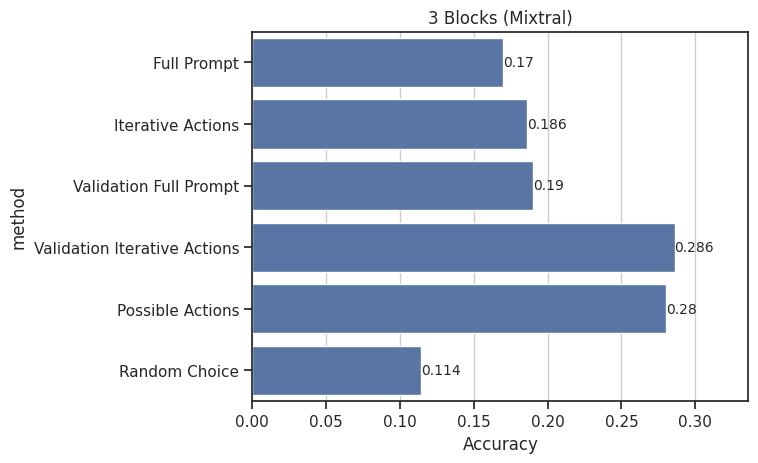

In [44]:
acc_by_method = df.groupby("method", as_index=False)["correct_response"].mean()
acc_by_method["method"] = acc_by_method["method"].apply(method_number_to_name)
ax = sn.barplot(acc_by_method, x="correct_response", y="method", orient="h")
ax.xaxis.grid(True)
ax.bar_label(ax.containers[0], fontsize=10);
ax.set_xlim([0, max(acc_by_method["correct_response"])+0.05])
ax.set_xlabel("Accuracy");
ax.set_title("3 Blocks (Mixtral)");

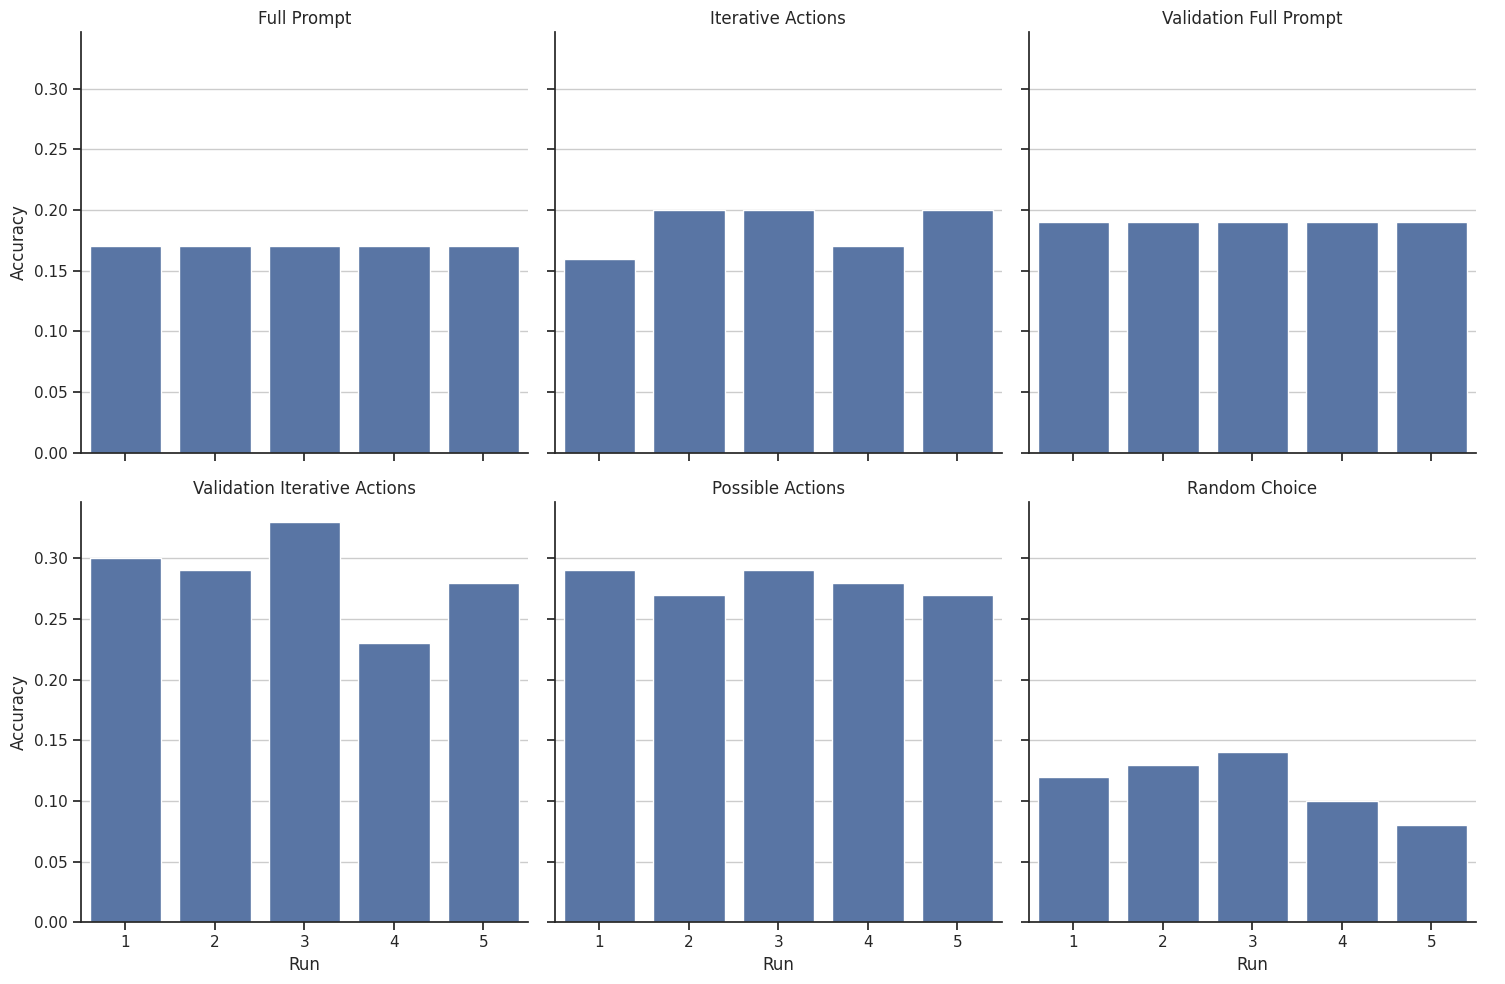

In [45]:
data = df.groupby(["method", "n_run"], as_index=False)["correct_response"].mean()
data_std = data.groupby("method", as_index=False)["correct_response"].std()
data["method"] = data["method"].apply(method_number_to_name)
data_std["method"] = data_std["method"].apply(method_number_to_name)
ax = sn.catplot(data, col="method", y="correct_response", x="n_run", kind="bar", col_wrap=3)
method_names = list(map(method_number_to_name, [0, 1, 2, 3, 4, 5]))
for i, ax in enumerate(ax.axes_dict.values()):
    ax.set_title(method_names[i])
    ax.yaxis.grid(True)
    ax.set_xlabel("Run")
    ax.set_ylabel("Accuracy")

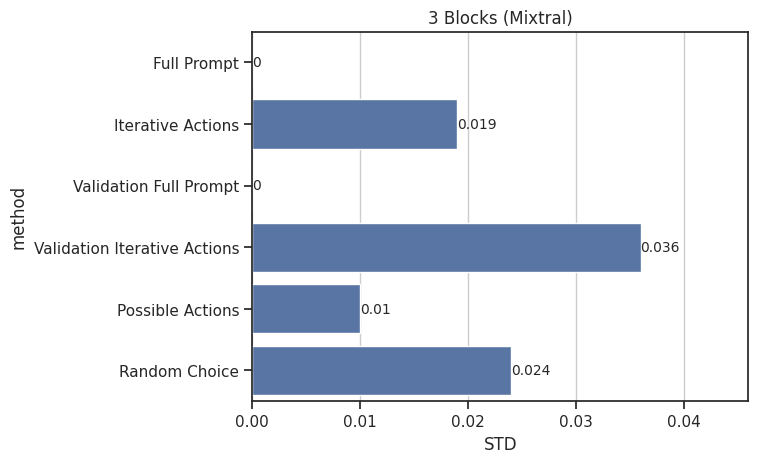

In [46]:
data_std["correct_response"] = data_std["correct_response"].round(3)
ax = sn.barplot(data_std, x="correct_response", y="method", orient="h")
ax.xaxis.grid(True)
ax.bar_label(ax.containers[0], fontsize=10);
ax.set_xlim([0, max(data_std["correct_response"])+0.01])
ax.set_xlabel("STD");
ax.set_title("3 Blocks (Mixtral)");

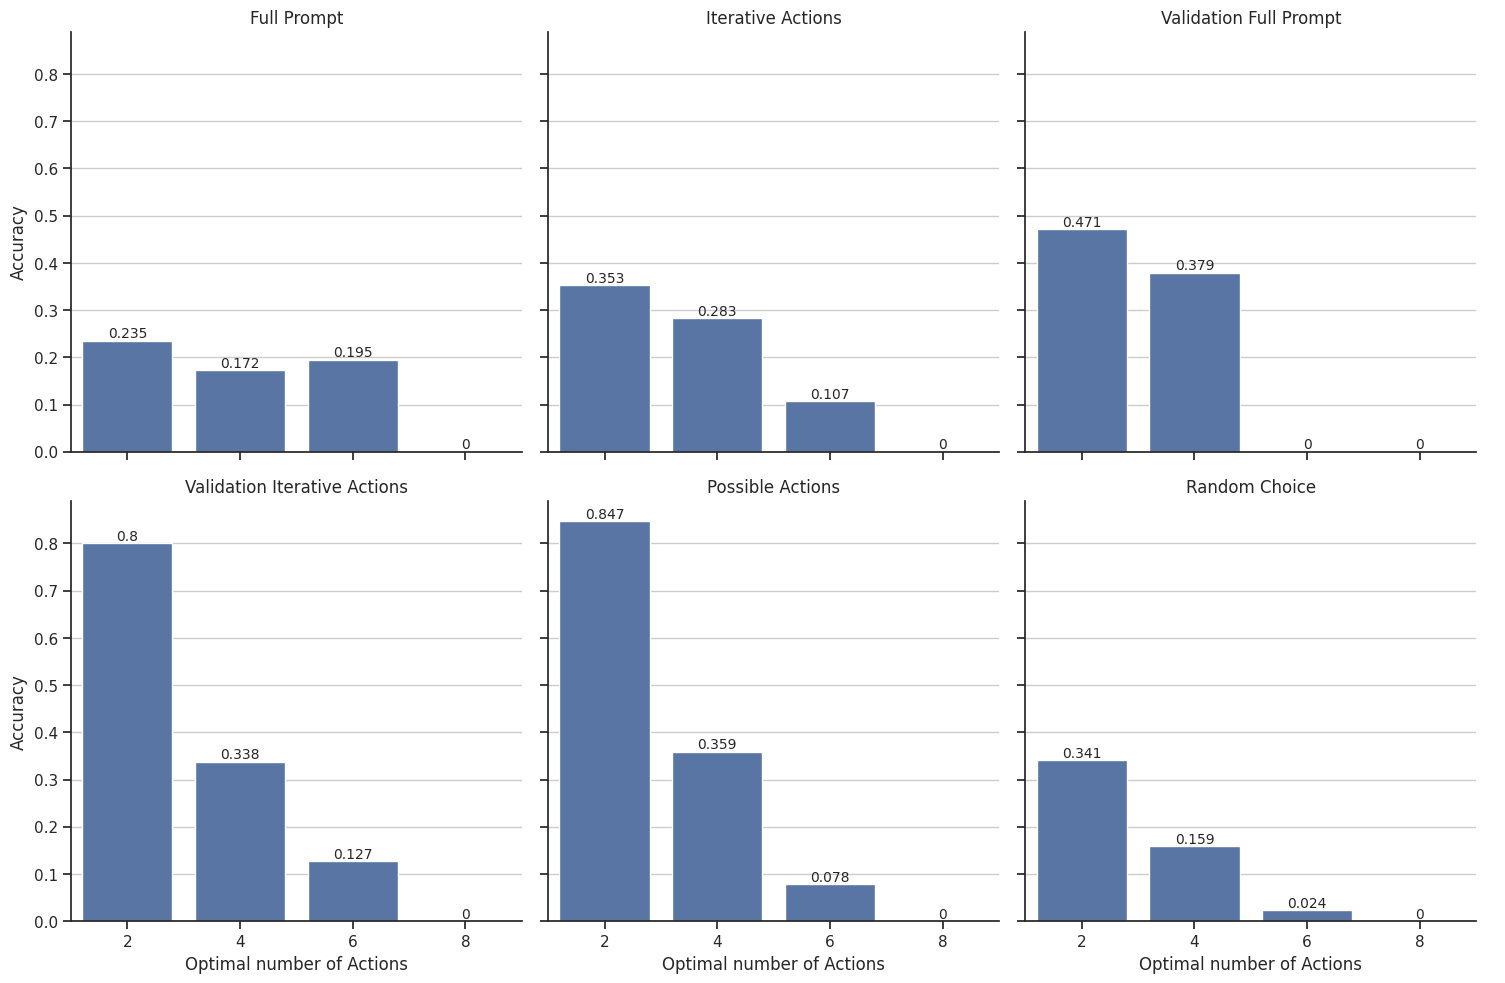

In [47]:
acc_by_method_gd_actions = df.groupby(["method", "ground_truth_n_actions"], as_index=False)["correct_response"].mean()
acc_by_method_gd_actions["correct_response"] = acc_by_method_gd_actions["correct_response"].round(3)
acc_by_method_gd_actions["method"] = acc_by_method_gd_actions["method"].apply(method_number_to_name)
ax = sn.catplot(acc_by_method_gd_actions, col="method", y="correct_response", x="ground_truth_n_actions", kind="bar", col_wrap=3)
method_names = list(map(method_number_to_name, [0, 1, 2, 3, 4, 5]))
for i, ax in enumerate(ax.axes_dict.values()):
    ax.set_title(method_names[i])
    ax.yaxis.grid(True)
    ax.bar_label(ax.containers[0], fontsize=10);
    ax.set_xlabel("Optimal number of Actions")
    ax.set_ylabel("Accuracy")

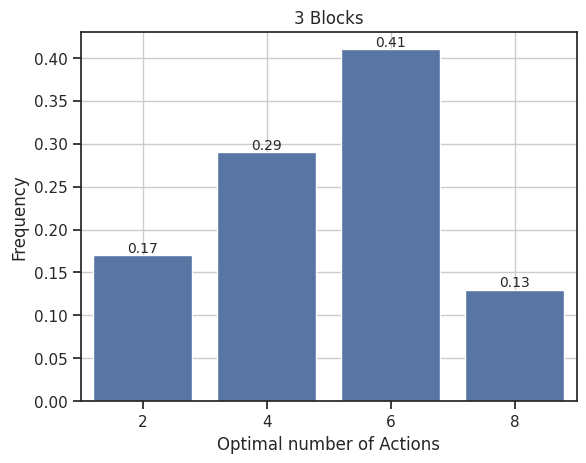

In [48]:
data = df.groupby("ground_truth_n_actions")["correct_response"].count()
data = data / data.sum()
ax = sn.barplot(x=data.index, y=data.values)
ax.bar_label(ax.containers[0], fontsize=10);
ax.grid(True)
ax.set_title("3 Blocks");
ax.set_xlabel("Optimal number of Actions");
ax.set_ylabel("Frequency");

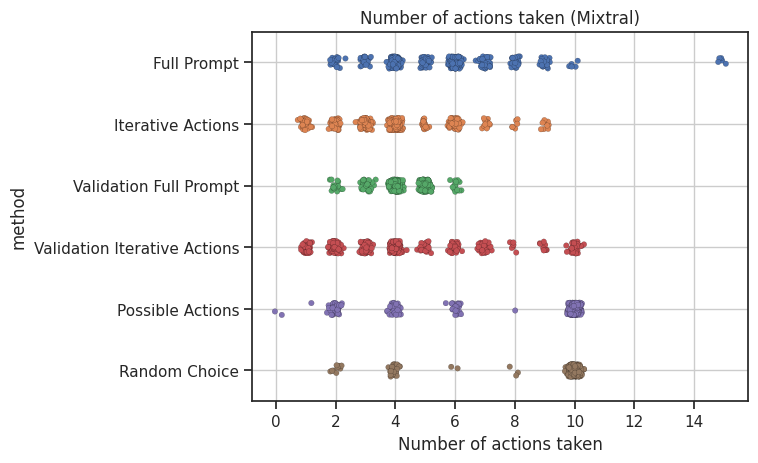

In [49]:
data = df.copy()
data["n_actions"] = data["n_actions"] + np.random.randn(data.shape[0])/10
ax = sn.stripplot(data, y="method", x="n_actions", orient="h", size=4, edgecolor="Black", linewidth=0.1, hue="method_name", legend=False)
method_names = map(method_number_to_name, [0, 1, 2, 3, 4, 5])
ax.grid(True)
ax.set_yticklabels(method_names);
ax.set_title("Number of actions taken (Mixtral)");
ax.set_xlabel("Number of actions taken");

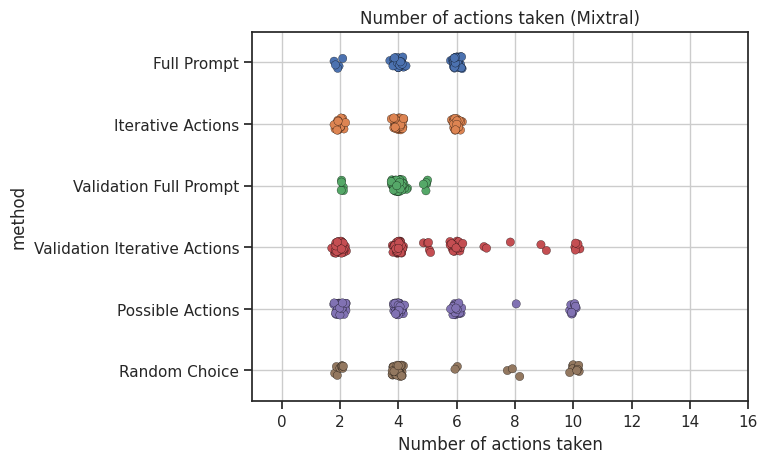

In [50]:
data = df[df["correct_response"] == True]
data["n_actions"] = data["n_actions"] + np.random.randn(data.shape[0])/10
ax = sn.stripplot(data, y="method", x="n_actions", orient="h", size=6, edgecolor="Black", linewidth=0.2, hue="method_name", legend=False)
method_names = map(method_number_to_name, [0, 1, 2, 3, 4, 5])
ax.set_xlim([-1, 16])
ax.grid(True)
ax.set_yticklabels(method_names);
ax.set_title("Number of actions taken (Mixtral)");
ax.set_xlabel("Number of actions taken");

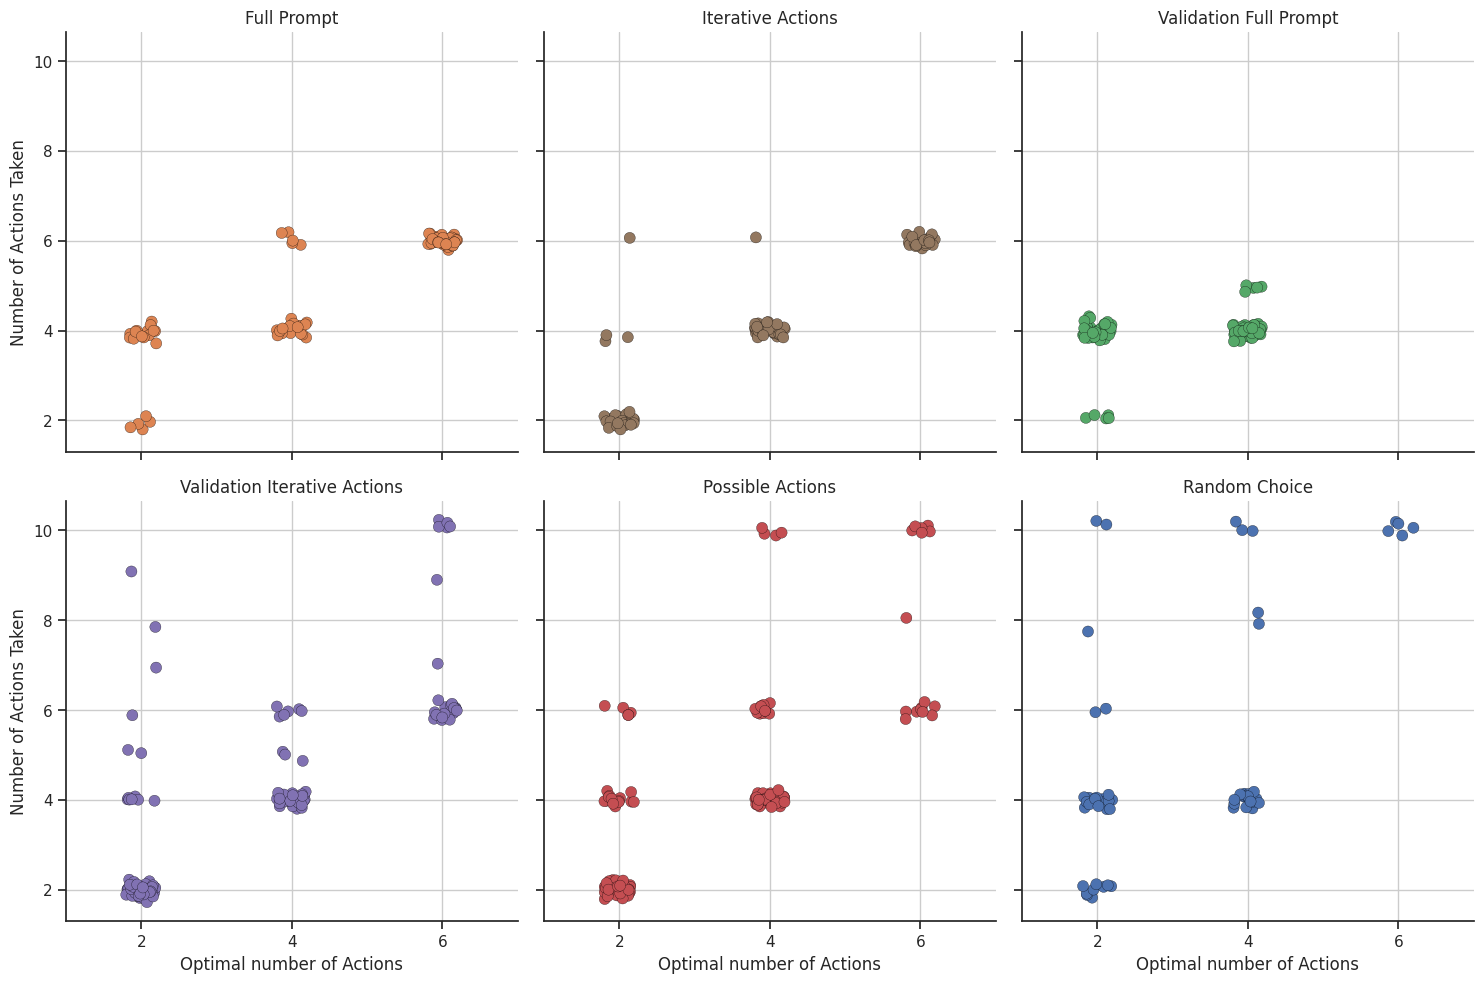

In [51]:
ax = sn.catplot(data, x="ground_truth_n_actions", y="n_actions", col="method", size=8, edgecolor="Black", linewidth=0.2, hue="method_name", legend=False, col_wrap=3)
method_names = list(map(method_number_to_name, [0, 1, 2, 3, 4, 5]))
for i, ax in enumerate(ax.axes_dict.values()):
    ax.set_title(method_names[i])
    ax.xaxis.grid(True)
    ax.yaxis.grid(True)
    ax.set_xlabel("Optimal number of Actions")
    ax.set_ylabel("Number of Actions Taken")

In [52]:
df_balanced = get_balanced_df(df)

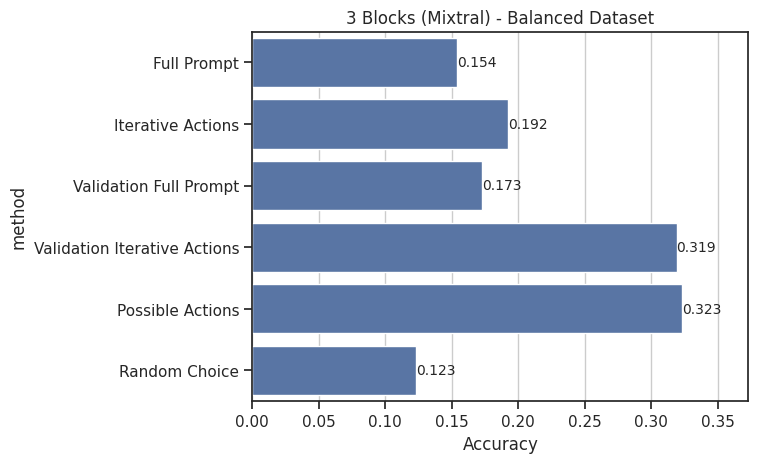

In [55]:
acc_by_method = df_balanced.groupby("method", as_index=False)["correct_response"].mean().round(3)
acc_by_method["method"] = acc_by_method["method"].apply(method_number_to_name)
ax = sn.barplot(acc_by_method, x="correct_response", y="method", orient="h")
ax.xaxis.grid(True)
ax.bar_label(ax.containers[0], fontsize=10);
ax.set_xlim([0, max(acc_by_method["correct_response"])+0.05])
ax.set_xlabel("Accuracy");
ax.set_title("3 Blocks (Mixtral) - Balanced Dataset");

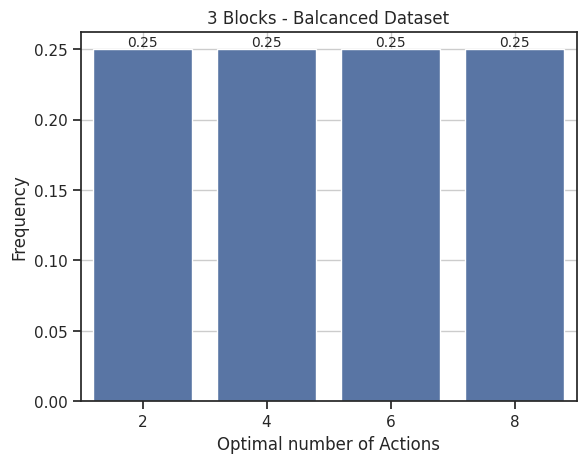

In [56]:
data = df_balanced.groupby("ground_truth_n_actions")["correct_response"].count()
data = data / data.sum()
ax = sn.barplot(x=data.index, y=data.values)
ax.bar_label(ax.containers[0], fontsize=10);
ax.grid(True)
ax.set_title("3 Blocks - Balcanced Dataset");
ax.set_xlabel("Optimal number of Actions");
ax.set_ylabel("Frequency");

In [37]:
df_few_shot = df[df["method"].isin([0, 2])]

In [53]:
def get_n_few_shot_actions(content: str) -> int:
    actions = content.split("[PLAN]")[1].split("[PLAN END]")[0].split("\n")
    return len(actions)-2

In [54]:
df_few_shot["n_few_shot_actions"] = df_few_shot["content"].apply(get_n_few_shot_actions)

In [99]:
df_few_shot[df_few_shot["method"] == 2].groupby("n_few_shot_actions")["correct_response"].mean()

n_few_shot_actions
2    0.117647
4    0.089655
6    0.275000
8    0.371429
Name: correct_response, dtype: float64

In [104]:
data = df_few_shot[df_few_shot["method"] == 2]
data = data.groupby(["ground_truth_n_actions", "n_few_shot_actions"], as_index=False)["correct_response"].mean()

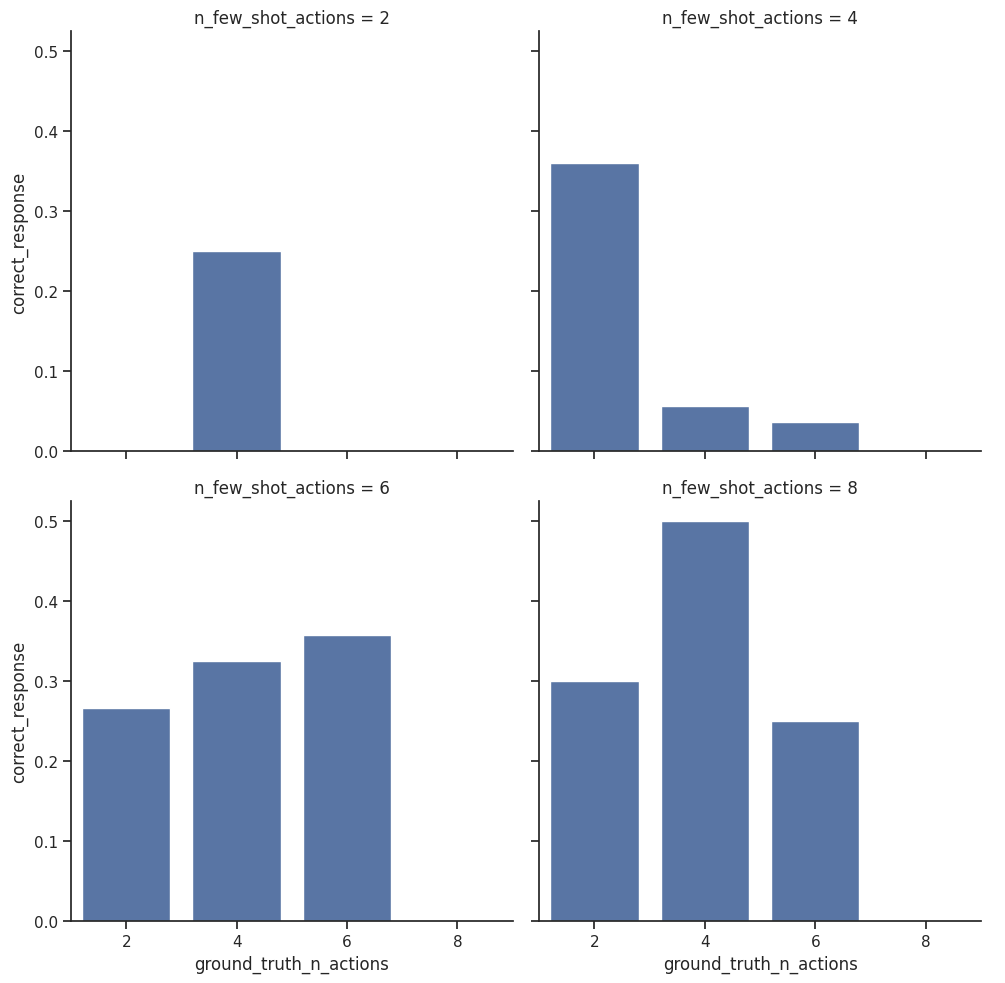

In [105]:
ax = sn.catplot(data, col="n_few_shot_actions", y="correct_response", x="ground_truth_n_actions", kind="bar", col_wrap=2)

In [61]:
csv_types = ["only_prompt_g", "iterative_actions_g", "only_prompt_iterative_g", "chat_g", "chat_with_possible_actions_g", "chat_random_choice_g"]
folder_path = "experiments_results/mixtra_5_4_blocks"
folder_path = Path(folder_path)
csv_files = folder_path.glob("*.csv")
df_concat = pd.DataFrame([])
for csv_file in csv_files:
    df = pd.read_csv(csv_file)
    file_name = csv_file.stem
    n_run = file_name[0]
    df_cat = [csv_type in file_name for csv_type in csv_types].index(True)
    if df_cat in [0, 1, 2]:
        df = pre_proc_df(df)
    else:
        df["correct_response"] = df["goal_achieved"]
    df = pre_proc_ground_truth(df, ground_truth_4_df)
    df["n_run"] = n_run
    df["method"] = df_cat
    df_concat = pd.concat([df_concat, df])
df = df_concat
df["method_name"] = df["method"].apply(method_number_to_name)

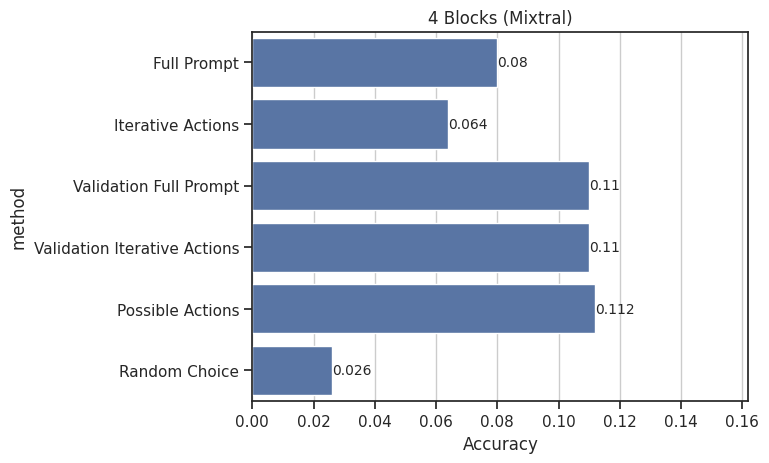

In [62]:
acc_by_method = df.groupby("method", as_index=False)["correct_response"].mean()
acc_by_method["method"] = acc_by_method["method"].apply(method_number_to_name)
ax = sn.barplot(acc_by_method, x="correct_response", y="method", orient="h")
ax.xaxis.grid(True)
ax.bar_label(ax.containers[0], fontsize=10);
ax.set_xlim([0, max(acc_by_method["correct_response"])+0.05])
ax.set_xlabel("Accuracy");
ax.set_title("4 Blocks (Mixtral)");

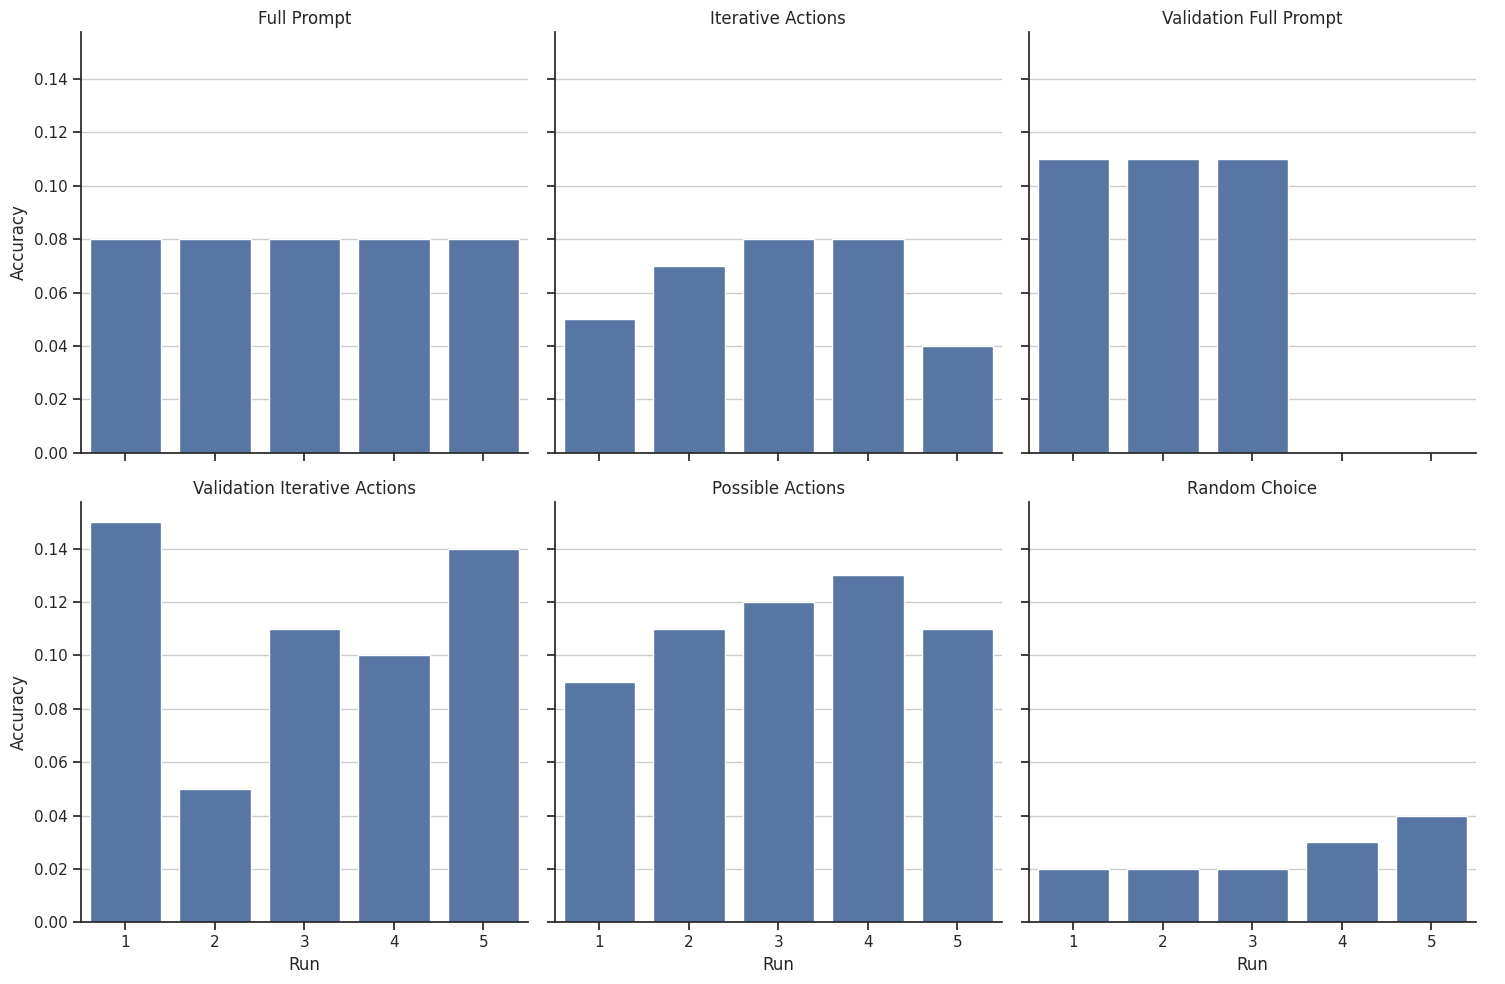

In [63]:
data = df.groupby(["method", "n_run"], as_index=False)["correct_response"].mean()
data_std = data.groupby("method", as_index=False)["correct_response"].std()
data["method"] = data["method"].apply(method_number_to_name)
data_std["method"] = data_std["method"].apply(method_number_to_name)
ax = sn.catplot(data, col="method", y="correct_response", x="n_run", kind="bar", col_wrap=3)
method_names = list(map(method_number_to_name, [0, 1, 2, 3, 4, 5]))
for i, ax in enumerate(ax.axes_dict.values()):
    ax.set_title(method_names[i])
    ax.yaxis.grid(True)
    ax.set_xlabel("Run")
    ax.set_ylabel("Accuracy")

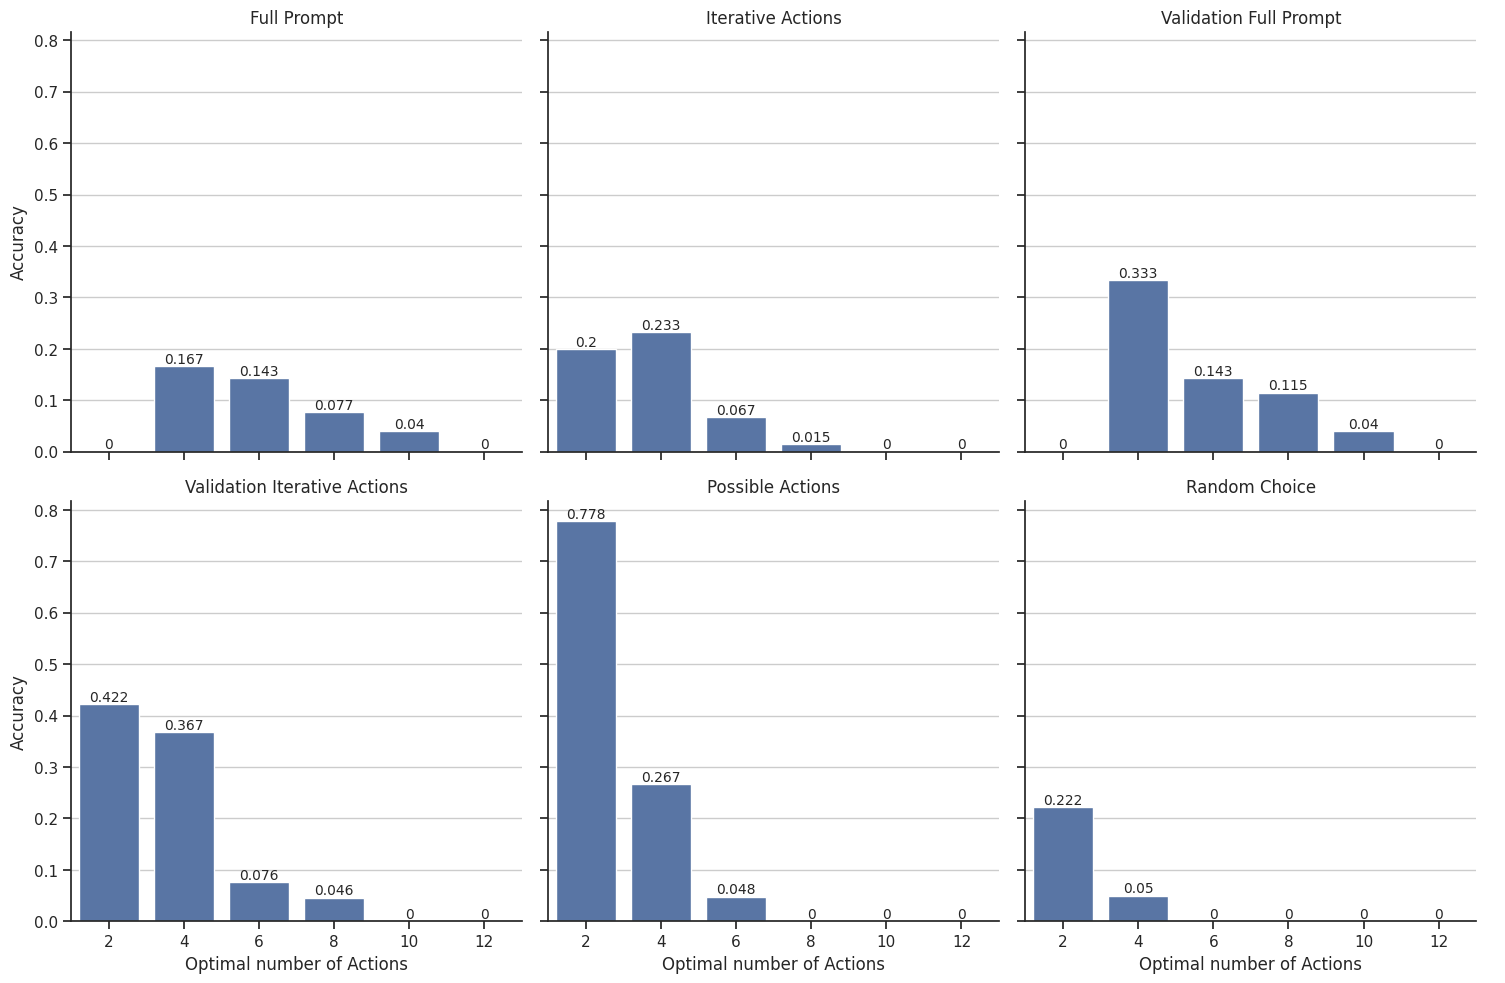

In [64]:
acc_by_method_gd_actions = df.groupby(["method", "ground_truth_n_actions"], as_index=False)["correct_response"].mean()
acc_by_method_gd_actions["correct_response"] = acc_by_method_gd_actions["correct_response"].round(3)
acc_by_method_gd_actions["method"] = acc_by_method_gd_actions["method"].apply(method_number_to_name)
ax = sn.catplot(acc_by_method_gd_actions, col="method", y="correct_response", x="ground_truth_n_actions", kind="bar", col_wrap=3)
method_names = list(map(method_number_to_name, [0, 1, 2, 3, 4, 5]))
for i, ax in enumerate(ax.axes_dict.values()):
    ax.set_title(method_names[i])
    ax.yaxis.grid(True)
    ax.bar_label(ax.containers[0], fontsize=10);
    ax.set_xlabel("Optimal number of Actions")
    ax.set_ylabel("Accuracy")

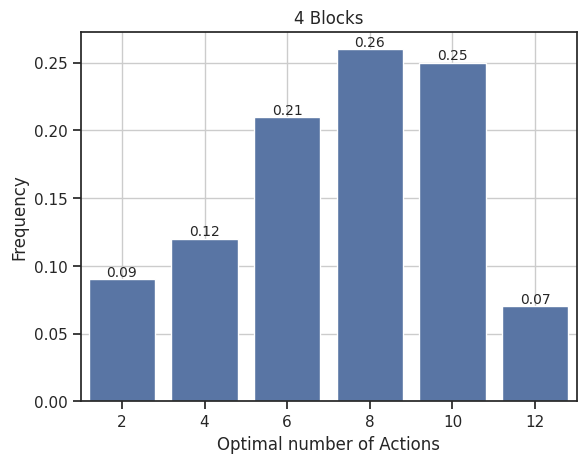

In [65]:
data = df.groupby("ground_truth_n_actions")["correct_response"].count()
data = data / data.sum()
ax = sn.barplot(x=data.index, y=data.values)
ax.bar_label(ax.containers[0], fontsize=10);
ax.grid(True)
ax.set_title("4 Blocks");
ax.set_xlabel("Optimal number of Actions");
ax.set_ylabel("Frequency");

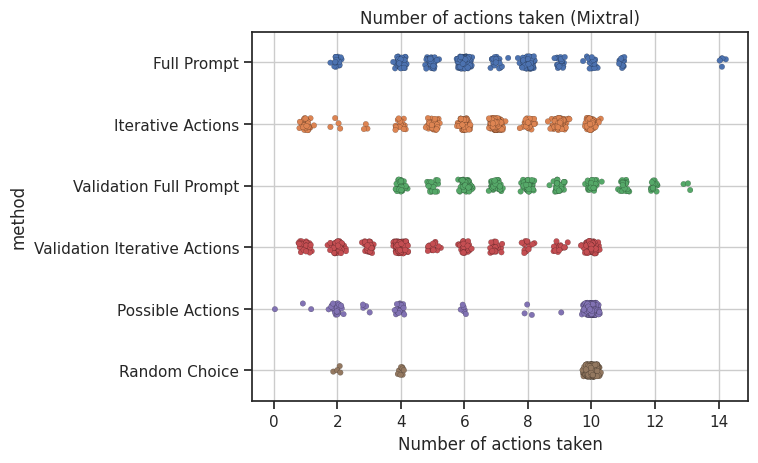

In [66]:
data = df.copy()
data["n_actions"] = data["n_actions"] + np.random.randn(data.shape[0])/10
ax = sn.stripplot(data, y="method", x="n_actions", orient="h", size=4, edgecolor="Black", linewidth=0.1, hue="method_name", legend=False)
method_names = map(method_number_to_name, [0, 1, 2, 3, 4, 5])
ax.grid(True)
ax.set_yticklabels(method_names);
ax.set_title("Number of actions taken (Mixtral)");
ax.set_xlabel("Number of actions taken");

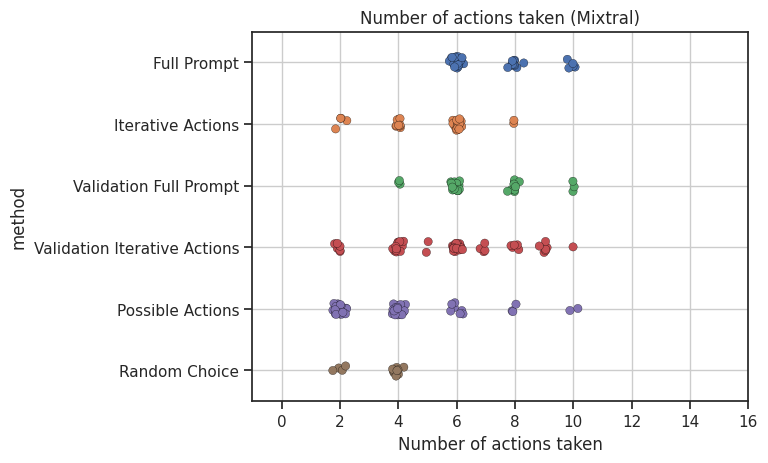

In [67]:
data = df[df["correct_response"] == True]
data["n_actions"] = data["n_actions"] + np.random.randn(data.shape[0])/10
ax = sn.stripplot(data, y="method", x="n_actions", orient="h", size=6, edgecolor="Black", linewidth=0.2, hue="method_name", legend=False)
method_names = map(method_number_to_name, [0, 1, 2, 3, 4, 5])
ax.set_xlim([-1, 16])
ax.grid(True)
ax.set_yticklabels(method_names);
ax.set_title("Number of actions taken (Mixtral)");
ax.set_xlabel("Number of actions taken");

In [68]:
df_balanced = get_balanced_df(df)

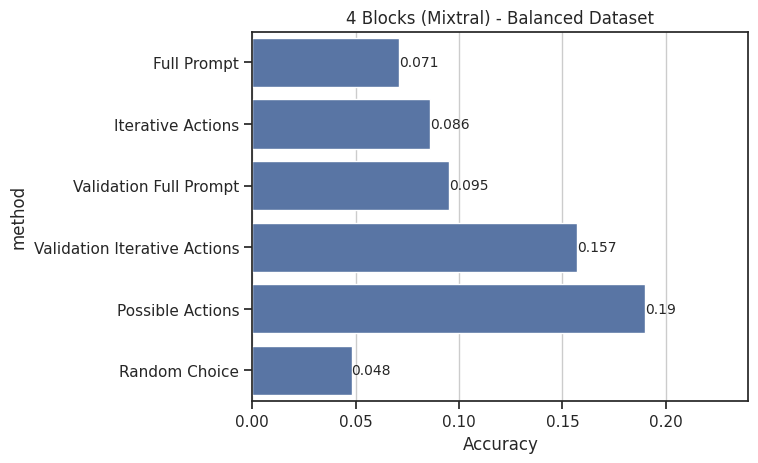

In [73]:
acc_by_method = df_balanced.groupby("method", as_index=False)["correct_response"].mean().round(3)
acc_by_method["method"] = acc_by_method["method"].apply(method_number_to_name)
ax = sn.barplot(acc_by_method, x="correct_response", y="method", orient="h")
ax.xaxis.grid(True)
ax.bar_label(ax.containers[0], fontsize=10);
ax.set_xlim([0, max(acc_by_method["correct_response"])+0.05])
ax.set_xlabel("Accuracy");
ax.set_title("4 Blocks (Mixtral) - Balanced Dataset");

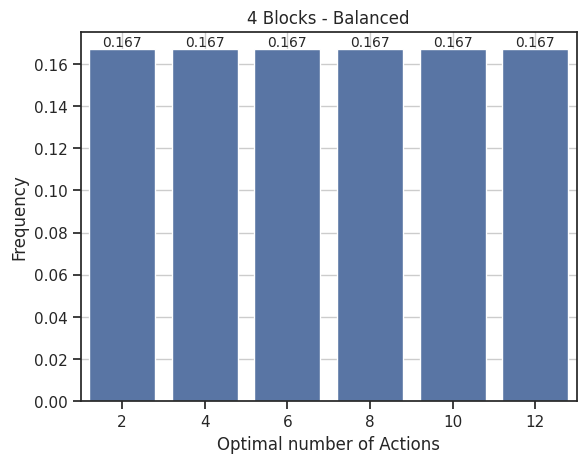

In [75]:
data = df_balanced.groupby("ground_truth_n_actions")["correct_response"].count()
data = (data / data.sum()).round(3)
ax = sn.barplot(x=data.index, y=data.values)
ax.bar_label(ax.containers[0], fontsize=10);
ax.grid(True)
ax.set_title("4 Blocks - Balanced");
ax.set_xlabel("Optimal number of Actions");
ax.set_ylabel("Frequency");

In [35]:
df_possible_actions = df[df["method"] == 4]

In [47]:
print(df_possible_actions[df_possible_actions["n_actions"] == 0].iloc[7]["content"])

human: I am playing with a set of blocks where I need to arrange the blocks into stacks. Here are the actions I can do

Pick up a block
Unstack a block from on top of another block
Put down a block
Stack a block on top of another block

I have the following restrictions on my actions:
I can only pick up or unstack one block at a time.
I can only pick up or unstack a block if my hand is empty.
I can only pick up a block if the block is on the table and the block is clear. A block is clear if the block has no other blocks on top of it and if the block is not picked up.
I can only unstack a block from on top of another block if the block I am unstacking was really on top of the other block.
I can only unstack a block from on top of another block if the block I am unstacking is clear.
Once I pick up or unstack a block, I am holding the block.
I can only put down a block that I am holding.
I can only stack a block on top of another block if I am holding the block being stacked.
I can only s

In [19]:
df = pd.read_csv("experiments_results/2024-03-25/3_iterative_actions_generated_basic_2_102_T_0_mixtral.csv")
df = pre_proc_df(df)
df = pre_proc_ground_truth(df, ground_truth_4_df) 

In [20]:
df[df["correct_response"] == True]["instance_id"].count()

8

In [56]:
df

,instance_id,goal_achieved,content,actions_text,actions_possible,n_actions,all_possible_actions,correct_response,ground_truth_plan,ground_truth_n_actions
0,2,True,human: I am playing with a set of blocks where...,pick up the red block.stack the red block on t...,1.1.1.1,4,True,True,(unstack yellow orange)\n(put-down yellow)\n(p...,4
1,3,False,human: I am playing with a set of blocks where...,unstack the blue block from on top of the oran...,1.1.1.0.0.0.0.1.0.0,10,False,False,(unstack blue orange)\n(put-down blue)\n(unsta...,10
2,4,False,human: I am playing with a set of blocks where...,unstack the blue block from on top of the oran...,0.0.0.0,4,False,False,(unstack yellow red)\n(put-down yellow)\n(unst...,10
3,5,False,human: I am playing with a set of blocks where...,unstack the red block from on top of the blue ...,1.1.0.0,4,False,False,(pick-up yellow)\n(stack yellow orange)\n,2
4,6,False,human: I am playing with a set of blocks where...,unstack the orange block from on top of the bl...,0.0.0.0,4,False,False,(unstack yellow red)\n(put-down yellow)\n(unst...,10
5,7,False,human: I am playing with a set of blocks where...,unstack the red block from on top of the orang...,1.1.0,3,False,False,(unstack red yellow)\n(put-down red)\n(unstack...,8
6,8,True,human: I am playing with a set of blocks where...,pick up the red block.stack the red block on t...,1.1,2,True,True,(unstack blue orange)\n(stack blue red)\n(pick...,8
7,9,False,human: I am playing with a set of blocks where...,unstack the red block from on top of the orang...,1.1.1.1.0,5,False,False,(unstack orange yellow)\n(put-down orange)\n(u...,10
8,10,False,human: I am playing with a set of blocks where...,the next best action is: unstack the red bloc...,0,1,False,False,(unstack orange blue)\n(put-down orange)\n(pic...,8
9,11,False,human: I am playing with a set of blocks where...,unstack the orange block from on top of the re...,1.1.0.0,4,False,False,(unstack red yellow)\n(put-down red)\n(pick-up...,6


In [93]:
df[df["correct_response"] == True]["instance_id"].unique()

array([ 2, 10, 12, 16, 20, 23, 45, 56, 59, 76, 83])

In [71]:
df = pd.read_csv("experiments_results/2024-03-24/24_14_35_only_prompt_iterative_generated_basic_2_102_T_0_mixtral.csv")
df = pre_proc_df(df)
df = pre_proc_ground_truth(df, ground_truth_4_df) 

In [73]:
df[df["correct_response"] == True].count()

instance_id               11
goal_achieved             11
content                   11
actions_text              11
actions_possible          11
n_actions                 11
all_possible_actions      11
correct_response          11
ground_truth_plan         11
ground_truth_n_actions    11
dtype: int64

In [77]:
df = pd.read_csv("experiments_results/2024-03-25/25_12_11_chat_generated_basic_2_102_T_0_mixtral.csv")
df["correct_response"] = df["goal_achieved"]
df = pre_proc_ground_truth(df, ground_truth_4_df) 

In [63]:
df_list = []
for i in range(1, 6):
    df = pd.read_csv(f"experiments_results/2024-03-22/{i}_only_prompt_iterative_generated_basic_3_2_102_T_0_mixtral.csv")
    #df = pre_proc_df(df)
    df["correct_response"] = df["goal_achieved"]
    df = pre_proc_ground_truth(df, ground_truth_df)
    df_list.append(df)

In [64]:
names_list = ["Full Plan", "Iterative Action", "Validation Full Plan", "Validation Iterative Action", "Possible Actions"]
acc_list = list(map(get_acc, df_list))

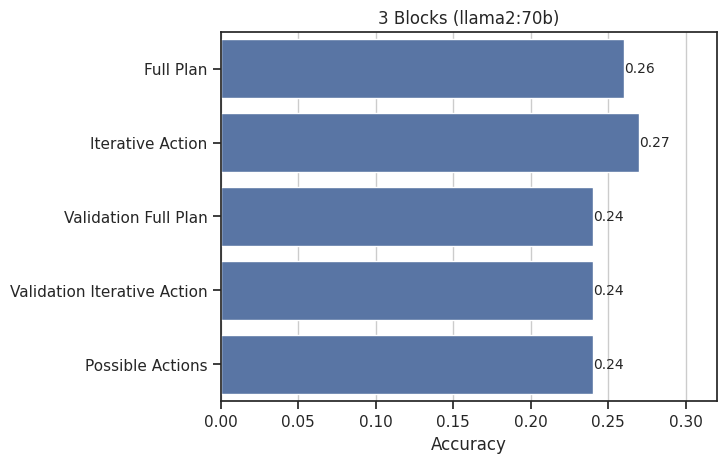

In [65]:
ax = sn.barplot(x=acc_list, y=names_list, orient="h")
ax.xaxis.grid(True)
ax.bar_label(ax.containers[0], fontsize=10);
ax.set_xlim([0, max(acc_list)+0.05])
ax.set_xlabel("Accuracy");
ax.set_title("3 Blocks (llama2:70b)");

In [107]:
df = pd.read_csv("experiments_results/2024-03-21/only_prompt_iterative_generated_basic_3_2_102_T_0_mixtral.csv")
df = pre_proc_df(df)
df = pre_proc_ground_truth(df, ground_truth_df)

In [110]:
df[df["correct_response"] == True]["goal_achieved"].sum()

18

In [111]:
df_1 = pd.read_csv("experiments_results/2024-03-21/only_prompt_generated_basic_3_2_102_T_0_mixtral.csv")
df_1 = pre_proc_df(df_1)
df_1 = pre_proc_ground_truth(df_1, ground_truth_df)

In [113]:
df_1[df_1["correct_response"] == True]["goal_achieved"].sum()

15

In [89]:
print(df.iloc[1]["content"])

human: I am playing with a set of blocks where I need to arrange the blocks into stacks. Here are the actions I can do

Pick up a block
Unstack a block from on top of another block
Put down a block
Stack a block on top of another block

I have the following restrictions on my actions:
I can only pick up or unstack one block at a time.
I can only pick up or unstack a block if my hand is empty.
I can only pick up a block if the block is on the table and the block is clear. A block is clear if the block has no other blocks on top of it and if the block is not picked up.
I can only unstack a block from on top of another block if the block I am unstacking was really on top of the other block.
I can only unstack a block from on top of another block if the block I am unstacking is clear.
Once I pick up or unstack a block, I am holding the block.
I can only put down a block that I am holding.
I can only stack a block on top of another block if I am holding the block being stacked.
I can only s

In [17]:
df_llama70b_list = get_analysis_from_folder("experiments_results/llama70", ground_truth_df)

In [18]:
names_list = ["Full Plan", "Iterative Action", "Validation Full Plan", "Validation Iterative Action", "Possible Actions"]
acc_list = list(map(get_acc, df_llama70b_list))
n_actions_mean_list = list(map(get_mean_n_actions, df_llama70b_list))
ground_truth_n_actions_list = list(map(get_ground_truth_n_actions, df_llama70b_list))
n_actions_list = list(map(get_n_actions, df_llama70b_list))
all_n_actions_list = list(map(get_all_n_actions, df_llama70b_list))
all_ground_n_actions = list(map(get_all_ground_truth_n_actions, df_llama70b_list))

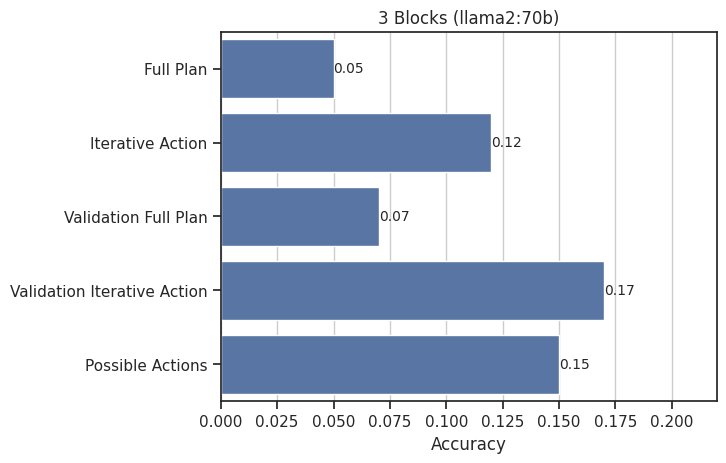

In [19]:
ax = sn.barplot(x=acc_list, y=names_list, orient="h")
ax.xaxis.grid(True)
ax.bar_label(ax.containers[0], fontsize=10);
ax.set_xlim([0, max(acc_list)+0.05])
ax.set_xlabel("Accuracy");
ax.set_title("3 Blocks (llama2:70b)");

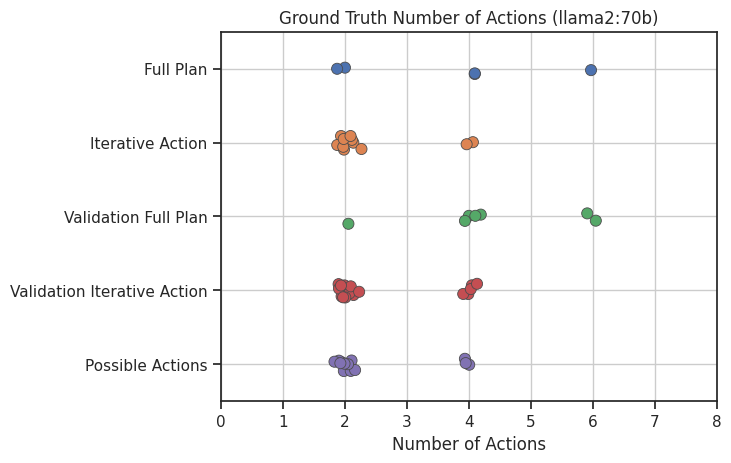

In [20]:
sn.set_theme(style="ticks")
ax = sn.stripplot(ground_truth_n_actions_list, orient="h", size=8, linewidth=0.6)
ax.grid(True)
ax.set_yticklabels(names_list)
ax.set_xlim([0, 8])
ax.set_xlabel("Number of Actions");
ax.set_title("Ground Truth Number of Actions (llama2:70b)");

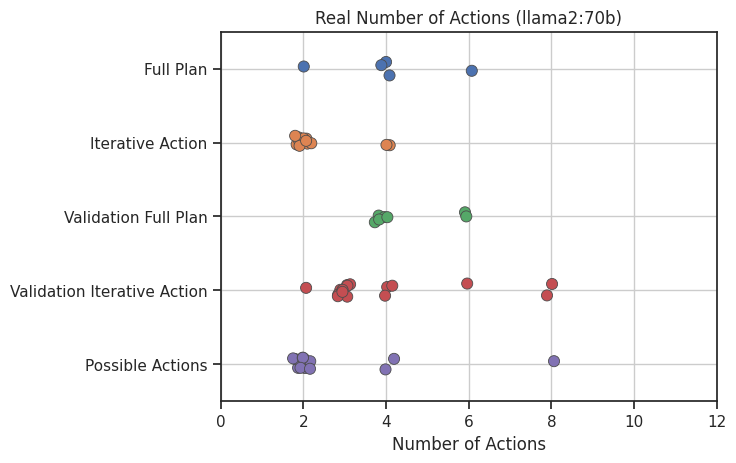

In [21]:
sn.set_theme(style="ticks")
ax = sn.stripplot(n_actions_list, orient="h", size=8, linewidth=0.6)
ax.grid(True)
ax.set_xlim([0, 12])
ax.set_yticklabels(names_list)
ax.set_xlabel("Number of Actions");
ax.set_title("Real Number of Actions (llama2:70b)");

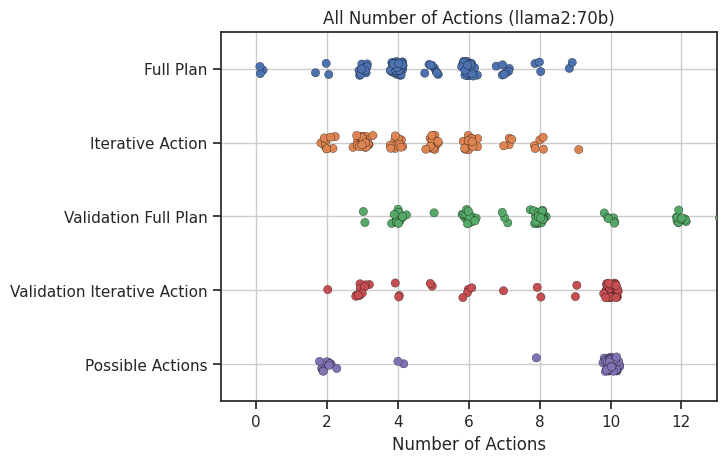

In [24]:
sn.set_theme(style="ticks")
ax = sn.stripplot(all_n_actions_list, orient="h", size=6, edgecolor="Black", linewidth=0.2)
ax.grid(True)
ax.set_xlim([-1, 13])
ax.set_yticklabels(names_list)
ax.set_xlabel("Number of Actions");
ax.set_title("All Number of Actions (llama2:70b)");

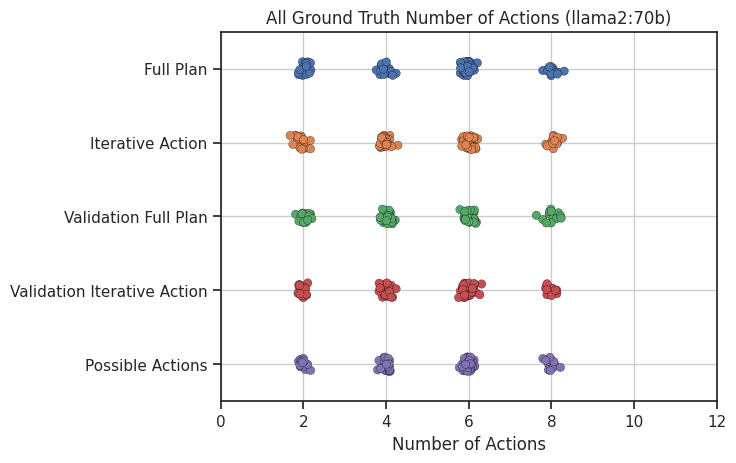

In [25]:
sn.set_theme(style="ticks")
ax = sn.stripplot(all_ground_n_actions, orient="h", size=6, edgecolor="Black", linewidth=0.2)
ax.grid(True)
ax.set_xlim([0, 12])
ax.set_yticklabels(names_list)
ax.set_xlabel("Number of Actions");
ax.set_title("All Ground Truth Number of Actions (llama2:70b)");

In [114]:
df_mixtral_list = get_analysis_from_folder("experiments_results/mixtral", ground_truth_df)

In [115]:
names_list = ["Full Plan", "Iterative Action", "Validation Full Plan", "Validation Iterative Action", "Possible Actions"]
acc_list = list(map(get_acc, df_mixtral_list))
n_actions_mean_list = list(map(get_mean_n_actions, df_mixtral_list))
ground_truth_n_actions_list = list(map(get_ground_truth_n_actions, df_mixtral_list))
n_actions_list = list(map(get_n_actions, df_mixtral_list))
all_n_actions_list = list(map(get_all_n_actions, df_mixtral_list))

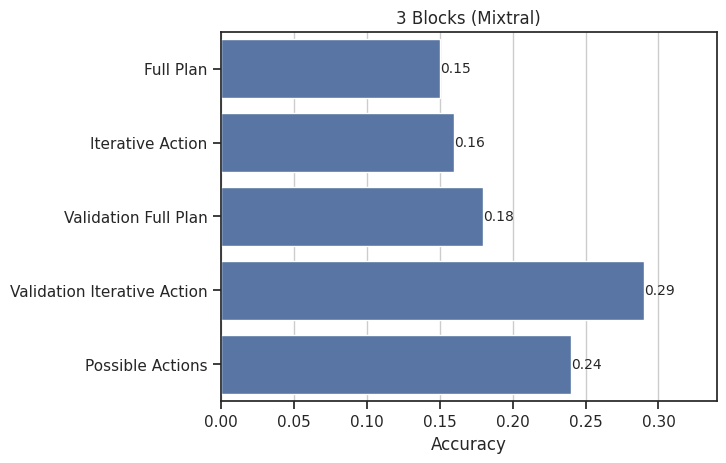

In [116]:
ax = sn.barplot(x=acc_list, y=names_list, orient="h")
ax.xaxis.grid(True)
ax.bar_label(ax.containers[0], fontsize=10);
ax.set_xlabel("Accuracy");
ax.set_xlim([0, max(acc_list) + 0.05])
ax.set_title("3 Blocks (Mixtral)");

In [81]:
df = df_mixtral_list[2]
content = df[df["correct_response"] == True].iloc[0]["content"]
df[df["correct_response"] == True].iloc[0]

instance_id                                                               2
goal_achieved                                                          True
content                   human: I am playing with a set of blocks where...
actions_text              pick up the red block.stack the red block on t...
actions_possible                                                    1.1.1.1
n_actions                                                                 4
all_possible_actions                                                   True
correct_response                                                       True
ground_truth_plan         (pick-up red)\n(stack red orange)\n(pick-up bl...
ground_truth_n_actions                                                    4
Name: 0, dtype: object

In [80]:
print(content)

human: I am playing with a set of blocks where I need to arrange the blocks into stacks. Here are the actions I can do

Pick up a block
Unstack a block from on top of another block
Put down a block
Stack a block on top of another block

I have the following restrictions on my actions:
I can only pick up or unstack one block at a time.
I can only pick up or unstack a block if my hand is empty.
I can only pick up a block if the block is on the table and the block is clear. A block is clear if the block has no other blocks on top of it and if the block is not picked up.
I can only unstack a block from on top of another block if the block I am unstacking was really on top of the other block.
I can only unstack a block from on top of another block if the block I am unstacking is clear.
Once I pick up or unstack a block, I am holding the block.
I can only put down a block that I am holding.
I can only stack a block on top of another block if I am holding the block being stacked.
I can only s

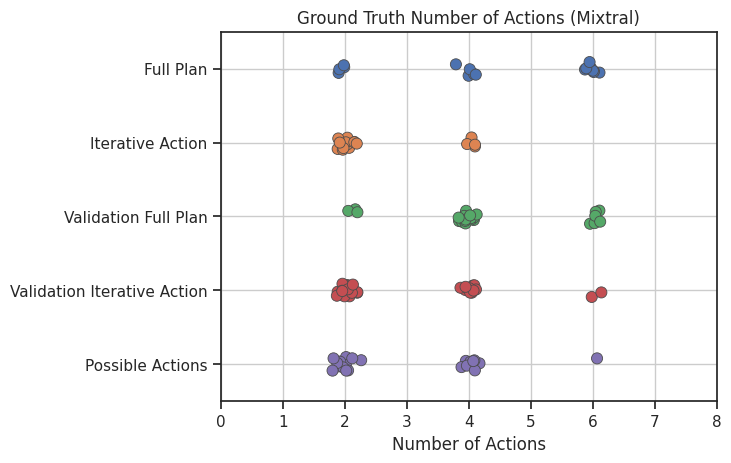

In [30]:
sn.set_theme(style="ticks")
ax = sn.stripplot(ground_truth_n_actions_list, orient="h", size=8, linewidth=0.6)
ax.grid(True)
ax.set_yticklabels(names_list)
ax.set_xlim([0, 8])
ax.set_xlabel("Number of Actions");
ax.set_title("Ground Truth Number of Actions (Mixtral)");

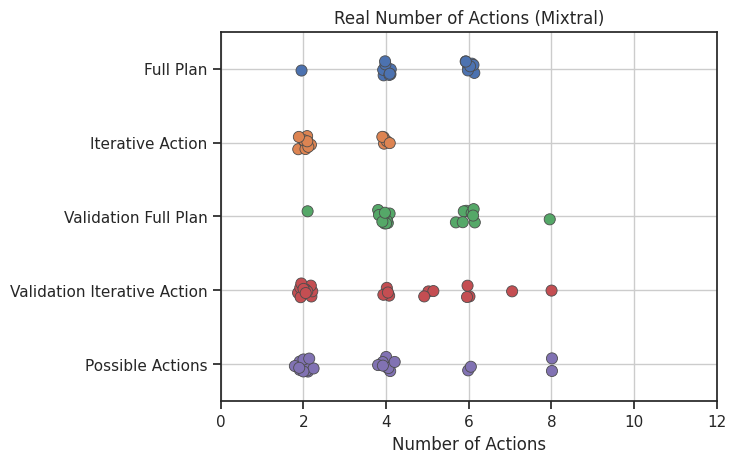

In [31]:
sn.set_theme(style="ticks")
ax = sn.stripplot(n_actions_list, orient="h", size=8, linewidth=0.6)
ax.grid(True)
ax.set_xlim([0, 12])
ax.set_yticklabels(names_list)
ax.set_xlabel("Number of Actions");
ax.set_title("Real Number of Actions (Mixtral)");

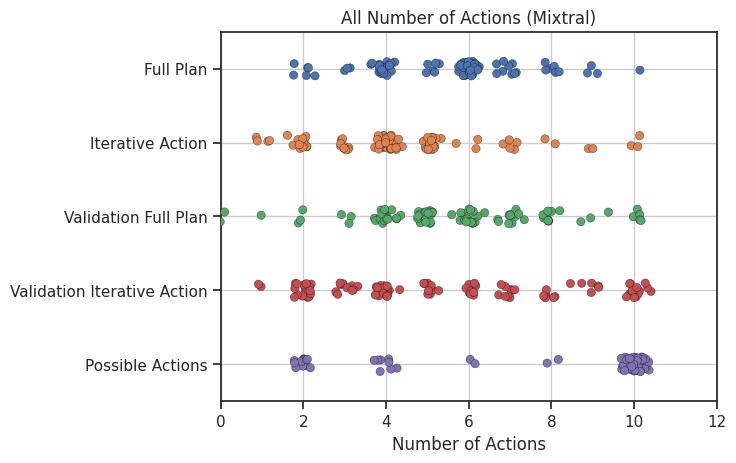

In [32]:
sn.set_theme(style="ticks")
ax = sn.stripplot(all_n_actions_list, orient="h", size=6, edgecolor="Black", linewidth=0.2)
ax.grid(True)
ax.set_xlim([0, 12])
ax.set_yticklabels(names_list)
ax.set_xlabel("Number of Actions");
ax.set_title("All Number of Actions (Mixtral)");

In [33]:
df_mixtral_4_list = get_analysis_from_folder("experiments_results/mixtral_4", ground_truth_4_df)

In [34]:
names_list = ["Full Plan", "Iterative Action", "Validation Full Plan", "Validation Iterative Action", "Possible Actions"]
acc_list = list(map(get_acc, df_mixtral_4_list))
n_actions_mean_list = list(map(get_mean_n_actions, df_mixtral_4_list))
ground_truth_n_actions_list = list(map(get_ground_truth_n_actions, df_mixtral_4_list))
n_actions_list = list(map(get_n_actions, df_mixtral_4_list))
all_n_actions_list = list(map(get_all_n_actions, df_mixtral_4_list))

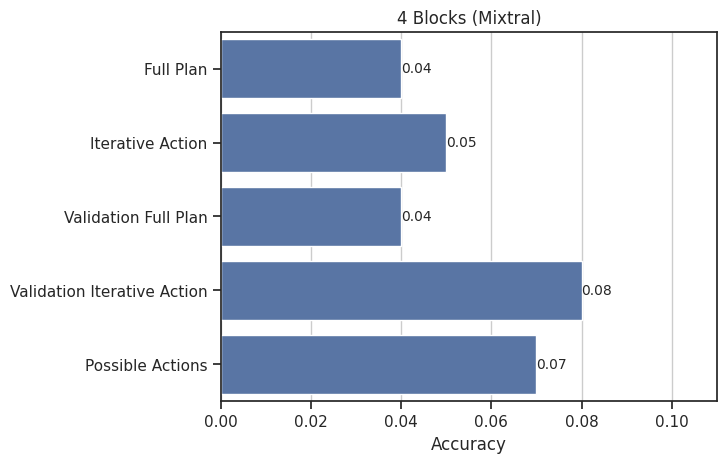

In [35]:
ax = sn.barplot(x=acc_list, y=names_list, orient="h")
ax.xaxis.grid(True)
ax.bar_label(ax.containers[0], fontsize=10);
ax.set_xlabel("Accuracy");
ax.set_xlim([0, max(acc_list) + 0.03])
ax.set_title("4 Blocks (Mixtral)");

In [67]:
df = df_mixtral_4_list[2]
all_chat = df[df["correct_response"] == True].iloc[0]["content"]
gt_actions = df[df["correct_response"] == True].iloc[0]["ground_truth_plan"]
actions = df[df["correct_response"] == True].iloc[0]["actions_text"]
df[df["correct_response"] == True]

,instance_id,goal_achieved,content,actions_text,actions_possible,n_actions,all_possible_actions,correct_response,ground_truth_plan,ground_truth_n_actions
10,12,True,human: I am playing with a set of blocks where...,unstack the blue block from on top of the yell...,1.1.1.1.1.1,6,True,True,(unstack blue yellow)\n(stack blue orange)\n(p...,4
37,39,True,human: I am playing with a set of blocks where...,unstack the yellow block from on top of the or...,1.1.1.1.1.1.1.1.1.1,10,True,True,(unstack yellow orange)\n(put-down yellow)\n(u...,10
87,89,True,human: I am playing with a set of blocks where...,unstack the red block from on top of the yello...,1.1.1.1.1.1,6,True,True,(unstack red yellow)\n(put-down red)\n(unstack...,6
131,133,True,human: I am playing with a set of blocks where...,unstack the red block from on top of the blue ...,1.1.1.1.1.1,6,True,True,(unstack red blue)\n(stack red yellow)\n(pick-...,4
162,164,True,human: I am playing with a set of blocks where...,pick up the orange block.stack the orange bloc...,1.1,2,True,True,(pick-up orange)\n(stack orange red)\n,2
164,166,True,human: I am playing with a set of blocks where...,unstack the orange block from on top of the ye...,1.1.1.1.1.1,6,True,True,(unstack orange yellow)\n(stack orange blue)\n...,6
183,185,True,human: I am playing with a set of blocks where...,unstack the red block from on top of the orang...,1.1.1.1.1.1,6,True,True,(unstack red orange)\n(stack red blue)\n(pick-...,6
195,197,True,human: I am playing with a set of blocks where...,unstack the orange block from on top of the bl...,1.1.1.1.1.1.1.1,8,True,True,(unstack orange blue)\n(put-down orange)\n(uns...,8


In [65]:
gt_actions

'(unstack blue yellow)\n(stack blue orange)\n(pick-up yellow)\n(stack yellow red)\n'

In [69]:
actions.split(".")

['unstack the blue block from on top of the yellow block',
 'put down the blue block',
 'pick up the yellow block',
 'stack the yellow block on top of the red block',
 'pick up the blue block',
 'stack the blue block on top of the orange block']

In [70]:
print(all_chat)

human: I am playing with a set of blocks where I need to arrange the blocks into stacks. Here are the actions I can do

Pick up a block
Unstack a block from on top of another block
Put down a block
Stack a block on top of another block

I have the following restrictions on my actions:
I can only pick up or unstack one block at a time.
I can only pick up or unstack a block if my hand is empty.
I can only pick up a block if the block is on the table and the block is clear. A block is clear if the block has no other blocks on top of it and if the block is not picked up.
I can only unstack a block from on top of another block if the block I am unstacking was really on top of the other block.
I can only unstack a block from on top of another block if the block I am unstacking is clear.
Once I pick up or unstack a block, I am holding the block.
I can only put down a block that I am holding.
I can only stack a block on top of another block if I am holding the block being stacked.
I can only s

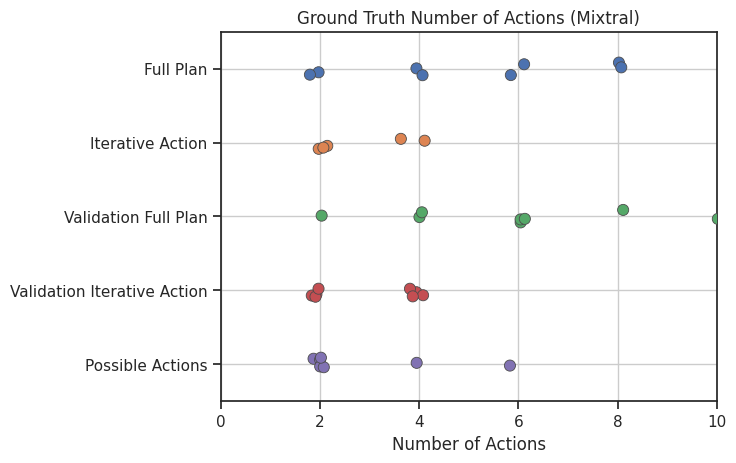

In [36]:
sn.set_theme(style="ticks")
ax = sn.stripplot(ground_truth_n_actions_list, orient="h", size=8, linewidth=0.6)
ax.grid(True)
ax.set_yticklabels(names_list)
ax.set_xlim([0, 10])
ax.set_xlabel("Number of Actions");
ax.set_title("Ground Truth Number of Actions (Mixtral)");

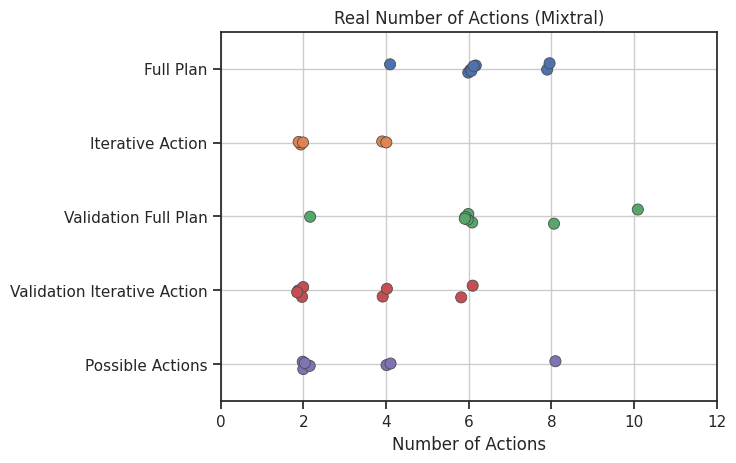

In [37]:
sn.set_theme(style="ticks")
ax = sn.stripplot(n_actions_list, orient="h", size=8, linewidth=0.6)
ax.grid(True)
ax.set_xlim([0, 12])
ax.set_yticklabels(names_list)
ax.set_xlabel("Number of Actions");
ax.set_title("Real Number of Actions (Mixtral)");

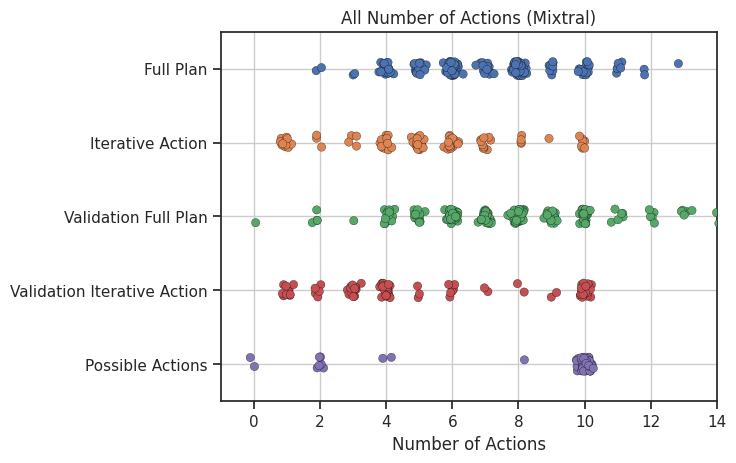

In [38]:
sn.set_theme(style="ticks")
ax = sn.stripplot(all_n_actions_list, orient="h", size=6, edgecolor="Black", linewidth=0.2)
ax.grid(True)
ax.set_xlim([-1, 14])
ax.set_yticklabels(names_list)
ax.set_xlabel("Number of Actions");
ax.set_title("All Number of Actions (Mixtral)");

In [33]:
df_1 = df_mixtral_4_list[0]
df_1[df_1["goal_achieved"] == True]

,instance_id,goal_achieved,content,actions_text,actions_possible,n_actions,all_possible_actions,correct_response,ground_truth_plan,ground_truth_n_actions
3,5,True,I am playing with a set of blocks where I need...,unstack the blue block from on top of the red ...,0.0.1.1.0.0,6,False,False,(unstack red blue)\n(put-down red)\n(unstack b...,8
8,10,True,I am playing with a set of blocks where I need...,unstack the orange block from on top of the bl...,1.1.1.1.1.1.1.1,8,True,True,(unstack blue orange)\n(put-down blue)\n(pick-...,6
10,12,True,I am playing with a set of blocks where I need...,unstack the blue block from on top of the yell...,1.1.1.1.1.1,6,True,True,(unstack blue red)\n(put-down blue)\n(pick-up ...,6
32,34,True,I am playing with a set of blocks where I need...,unstack the blue block from on top of the red ...,1.1.1.1.0.0,6,False,False,(unstack orange blue)\n(put-down orange)\n(pic...,4
39,41,True,I am playing with a set of blocks where I need...,unstack the blue block from on top of the oran...,1.1.0.0.0.0.1.1,8,False,False,(pick-up orange)\n(stack orange blue)\n,2
43,45,True,I am playing with a set of blocks where I need...,unstack the orange block from on top of the re...,1.1.1.1.1.1,6,True,True,(pick-up red)\n(stack red orange)\n,2
44,46,True,I am playing with a set of blocks where I need...,unstack the blue block from on top of the yell...,1.1.0.1.0.1.1.1,8,False,False,(unstack blue red)\n(stack blue orange)\n(pick...,4
57,59,True,I am playing with a set of blocks where I need...,unstack the blue block from on top of the red ...,1.1.1.1.1.1,6,True,True,(unstack blue red)\n(put-down blue)\n(unstack ...,6
62,64,True,I am playing with a set of blocks where I need...,unstack the blue block from on top of the red ...,1.1.0.1.1.1.1.1.1,9,False,False,(unstack red orange)\n(put-down red)\n(pick-up...,6
74,76,True,I am playing with a set of blocks where I need...,unstack the red block from on top of the blue ...,1.1.1.1.1.1.1.1,8,True,True,(unstack blue red)\n(put-down blue)\n(unstack ...,6


In [30]:
print(df_1.iloc[43]["content"])

I am playing with a set of blocks where I need to arrange the blocks into stacks. Here are the actions I can do

Pick up a block
Unstack a block from on top of another block
Put down a block
Stack a block on top of another block

I have the following restrictions on my actions:
I can only pick up or unstack one block at a time.
I can only pick up or unstack a block if my hand is empty.
I can only pick up a block if the block is on the table and the block is clear. A block is clear if the block has no other blocks on top of it and if the block is not picked up.
I can only unstack a block from on top of another block if the block I am unstacking was really on top of the other block.
I can only unstack a block from on top of another block if the block I am unstacking is clear.
Once I pick up or unstack a block, I am holding the block.
I can only put down a block that I am holding.
I can only stack a block on top of another block if I am holding the block being stacked.
I can only stack a 

In [35]:
df_2 = df_mixtral_4_list[2]
df_2[df_2["correct_response"] == True]

,instance_id,goal_achieved,content,actions_text,actions_possible,n_actions,all_possible_actions,correct_response,ground_truth_plan,ground_truth_n_actions
10,12,True,human: I am playing with a set of blocks where...,unstack the blue block from on top of the yell...,1.1.1.1.1.1,6,True,True,(unstack blue red)\n(put-down blue)\n(pick-up ...,6
87,89,True,human: I am playing with a set of blocks where...,unstack the red block from on top of the yello...,1.1.1.1.1.1,6,True,True,(pick-up blue)\n(stack blue red)\n,2


In [32]:
df_2.iloc[43]

instance_id                                                              45
goal_achieved                                                         False
content                   human: I am playing with a set of blocks where...
actions_text              pick up the blue block.stack the blue block on...
actions_possible                                                    1.1.1.1
n_actions                                                                 4
all_possible_actions                                                   True
correct_response                                                      False
ground_truth_plan                       (pick-up red)\n(stack red orange)\n
ground_truth_n_actions                                                    2
Name: 43, dtype: object

In [31]:
print(df_2.iloc[43]["content"])

human: I am playing with a set of blocks where I need to arrange the blocks into stacks. Here are the actions I can do

Pick up a block
Unstack a block from on top of another block
Put down a block
Stack a block on top of another block

I have the following restrictions on my actions:
I can only pick up or unstack one block at a time.
I can only pick up or unstack a block if my hand is empty.
I can only pick up a block if the block is on the table and the block is clear. A block is clear if the block has no other blocks on top of it and if the block is not picked up.
I can only unstack a block from on top of another block if the block I am unstacking was really on top of the other block.
I can only unstack a block from on top of another block if the block I am unstacking is clear.
Once I pick up or unstack a block, I am holding the block.
I can only put down a block that I am holding.
I can only stack a block on top of another block if I am holding the block being stacked.
I can only s